In [1]:
import requests
import pandas as pd
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

import cv2
import seaborn as sns

from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Helper functions for visualization:

In [2]:
# from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    From scikit-learn: plots a confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    #fixes "squishing of plot"
    plt.ylim([1.5, -.5]) 
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

def plot_model_history(history, n_epochs):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training Loss')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training Accuracy')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')

In [3]:
df0 = pd.read_fwf('PCC_cat.txt', header=None)
df0
# df0[21]

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,NaN,PCC-0001,49.2355,41.5722,20.51,0.04,1.44,0.10,20.80,1.07,...,0.69,0.25,0.63,0.28,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
1,NaN,PCC-0002,49.2366,41.4013,20.44,0.04,2.18,0.14,21.96,0.79,...,1.53,1.01,1.38,0.97,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
2,NaN,PCC-0003,49.2370,41.4336,21.58,0.04,1.11,0.07,22.41,0.07,...,1.25,0.71,1.19,0.67,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
3,NaN,PCC-0004,49.2377,41.5285,21.03,0.06,1.08,0.10,23.14,0.69,...,0.58,0.25,0.42,0.15,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
4,NaN,PCC-0005,49.2380,41.4346,20.27,0.02,1.24,0.04,21.94,0.80,...,0.70,0.50,0.53,0.48,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5432,NaN,PCC-5433,50.0062,41.2380,20.32,NaN,1.10,NaN,22.53,3.80,...,0.97,0.83,0.93,0.69,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5433,NaN,PCC-5434,50.0064,41.2568,22.63,NaN,0.54,NaN,23.29,0.50,...,1.46,1.12,NaN,NaN,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5434,NaN,PCC-5435,50.0068,41.6048,21.44,0.02,0.61,0.02,21.52,0.43,...,0.59,0.41,NaN,NaN,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5435,NaN,PCC-5436,50.0070,41.3916,21.32,0.07,0.99,0.10,22.86,0.95,...,1.19,1.07,1.06,0.92,NaN,NaN,Cluster or background LTG,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...


# Here we have 7 unique labels:

In [4]:
labels = np.unique(df0[21])

print(labels)
print(len(labels)) # number of unique labels

['Cluster or background LTG' 'Likely background ETG or unresolved source'
 'Likely cluster or background edge-on disk galaxy'
 'Likely dE/ETGcluster candidate' 'Likely merging system'
 'Possible dE/ETGcluster candidate'
 'background galaxy with possibly weak substructure']
7


# Make a dataframe of the images and associated labels

In [5]:
# access ra and dec from their columns in the datagframe
ra = df0[2]
dec = df0[3]
workDir = 'SDSS2'

# filenames = []
# for r, d in zip(ra, dec):
#     fn = f'sdss_ra={r}_dec={d}.jpeg'
#     filenames.append(fn)

# df1 = pd.DataFrame({'files' : filenames,
#                     'labels': df0[21]})    


In [6]:
# df1

In [7]:
bright = np.where(df0[4] <= 19.4)
brightDF = df0.iloc[bright].copy()

labels = np.unique(brightDF[21])

# print(labels)
# print(len(labels)) # number of unique labels


In [8]:
# img_dir = 'SDSS1'
# fileEx00 = df1.iloc[1883][0]
# galEx00 = load_img(os.path.join(img_dir, fileEx00))
# galEx00

# Check balance of labels/data

In [9]:
def checkBalance(df):
    all_labels = df['labels']
    all_labels = all_labels.tolist()

    balance = df['labels'].value_counts()
    print(balance)
    for i in range(len(balance)):
        print(f'{balance[i]*100/df.size:.2f} %')

In [10]:
# checkBalance(df1)

In [11]:
brightDF

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
5,NaN,PCC-0006,49.2388,41.4631,19.03,0.00,0.69,0.01,19.28,1.35,...,0.39,-0.11,NaN,NaN,NaN,NaN,Likely merging system,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
6,NaN,PCC-0007,49.2392,41.4215,19.26,0.03,0.97,0.05,20.76,3.79,...,1.02,0.68,0.88,0.66,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
7,NaN,PCC-0008,49.2411,41.4991,18.51,0.01,1.78,0.02,20.95,2.50,...,1.01,0.82,0.93,0.66,NaN,NaN,Cluster or background LTG,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
10,NaN,PCC-0011,49.2420,41.4454,19.19,0.01,1.51,0.02,21.95,1.02,...,0.83,0.59,0.70,0.47,NaN,NaN,Cluster or background LTG,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
25,NaN,PCC-0026,49.2466,41.4451,19.34,0.01,2.04,0.02,21.31,1.20,...,1.18,0.85,0.98,0.75,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5386,NaN,PCC-5387,49.9985,41.3856,18.60,0.01,2.84,0.06,22.78,2.45,...,0.88,0.70,0.82,0.65,NaN,NaN,Cluster or background LTG,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5407,NaN,PCC-5408,50.0018,41.6806,18.16,0.00,0.16,0.00,15.85,3.30,...,0.24,0.12,NaN,NaN,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5416,NaN,PCC-5417,50.0028,41.3384,18.84,0.01,1.27,0.02,20.74,2.42,...,1.05,0.75,0.78,0.71,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5422,NaN,PCC-5423,50.0040,41.3410,17.50,0.01,1.86,0.02,20.45,4.00,...,0.92,0.76,0.93,0.69,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...


In [12]:
# access ra and dec from their columns in the datagframe
ra = brightDF[2]
dec = brightDF[3]
workDir = 'SDSS2'

filenames = []
for r, d in zip(ra, dec):
    fn = f'sdss_ra={r}_dec={d}.jpeg'
    filenames.append(fn)

brightDF_reduced = pd.DataFrame({'files' : filenames,
                                 'labels': brightDF[21]})    

In [13]:
checkBalance(brightDF_reduced)

Likely dE/ETGcluster candidate                       121
Cluster or background LTG                             68
Likely background ETG or unresolved source            38
Likely cluster or background edge-on disk galaxy      31
background galaxy with possibly weak substructure      9
Likely merging system                                  3
Possible dE/ETGcluster candidate                       2
Name: labels, dtype: int64
22.24 %
12.50 %
6.99 %
5.70 %
1.65 %
0.55 %
0.37 %


In [14]:
df1 = brightDF_reduced
unique_labels = np.unique(df1['labels'])

unique_labels

array(['Cluster or background LTG',
       'Likely background ETG or unresolved source',
       'Likely cluster or background edge-on disk galaxy',
       'Likely dE/ETGcluster candidate', 'Likely merging system',
       'Possible dE/ETGcluster candidate',
       'background galaxy with possibly weak substructure'], dtype=object)

In [15]:
# df1.sort_values(by='labels')

clusterBG_LTG = df1.loc[(df1['labels']==unique_labels[0])]
BG_ETG = df1.loc[(df1['labels']==unique_labels[1])]
clusterBG_edgeDisk = df1.loc[(df1['labels']==unique_labels[2])]
likely_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[3])]
likely_merging = df1.loc[(df1['labels']==unique_labels[4])]
poss_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[5])]
weak_bg = df1.loc[(df1['labels']==unique_labels[6])]

In [16]:
clusterBG_LTG = df1.loc[(df1['labels']==unique_labels[0])]
BG_ETG = df1.loc[(df1['labels']==unique_labels[1])]
clusterBG_edgeDisk = df1.loc[(df1['labels']==unique_labels[2])]
likely_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[3])]
likely_merging = df1.loc[(df1['labels']==unique_labels[4])]
poss_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[5])]
weak_bg = df1.loc[(df1['labels']==unique_labels[6])]

In [17]:
downSampleDf0 = pd.concat([clusterBG_LTG, # 384
                         BG_ETG.sample(frac = 400/3008),
                         clusterBG_edgeDisk.sample(frac = 400/1049),
                         likely_dE_ETGcluster, # 398
                         likely_merging, # 23
                         poss_dE_ETGcluster, # 98
                         weak_bg # 477
                         ])
checkBalance(downSampleDf0)

Likely dE/ETGcluster candidate                       121
Cluster or background LTG                             68
Likely cluster or background edge-on disk galaxy      12
background galaxy with possibly weak substructure      9
Likely background ETG or unresolved source             5
Likely merging system                                  3
Possible dE/ETGcluster candidate                       2
Name: labels, dtype: int64
27.50 %
15.45 %
2.73 %
2.05 %
1.14 %
0.68 %
0.45 %


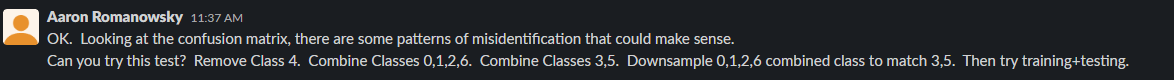

In [18]:
def replace(df, ind):
    label = list(df['labels'])[0]
    newDf = df.replace(label, str(ind))
    return(newDf)

In [19]:
# combined 3 and 5
second = pd.concat([
                    replace(likely_dE_ETGcluster, 1), # old 3
                    replace(poss_dE_ETGcluster, 1) # old 5
                    ])
# combine 0,1,2,6
first = pd.concat([replace(clusterBG_LTG, 0), # old 0
                   replace(BG_ETG, 0), # old 1
                   replace(clusterBG_edgeDisk, 0), # old 2
                   replace(weak_bg, 0) # old 6 
                    ])

lenSecond = len(second.index)
lenFirst = len(first.index)

downSampleDf1 = pd.concat([first.sample(frac = lenSecond/lenFirst), second])

# downSampleDf1

# Train/Test Split


In [20]:
X = downSampleDf1['files']
y = downSampleDf1['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

trainDf = pd.DataFrame({'files' : X_train,
                        'labels': y_train})  
testDf = pd.DataFrame({'files' : X_test,
                        'labels': y_test}) 

trainDf #randomized and split

,files,labels
1841,sdss_ra=49.5502_dec=41.4233.jpeg,1
2350,sdss_ra=49.6199_dec=41.6827.jpeg,0
4215,sdss_ra=49.8501_dec=41.5332.jpeg,1
984,sdss_ra=49.4134_dec=41.5176.jpeg,1
4296,sdss_ra=49.8585_dec=41.2621.jpeg,1
...,...,...
2340,sdss_ra=49.6184_dec=41.4546.jpeg,0
640,sdss_ra=49.3541_dec=41.4703.jpeg,0
825,sdss_ra=49.3878_dec=41.5814.jpeg,0
3163,sdss_ra=49.7177_dec=41.2676.jpeg,1


# Example Data and Labels:

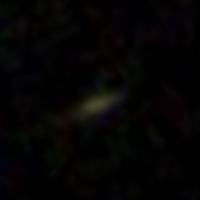

In [21]:
img_dir = 'SDSS1'
fileEx0 = 'sdss_ra=49.2355_dec=41.5722.jpeg'
galEx0 = load_img(os.path.join(img_dir, fileEx0))
galEx0

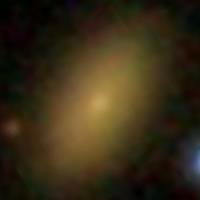

In [22]:
fileEx1 = 'sdss_ra=49.5028_dec=41.2991.jpeg'
galEx1 = load_img(os.path.join(img_dir, fileEx1))
galEx1

In [23]:
# search0 = df1['files']
# search0 = search0.to_list()
# labelEx0 = df1['labels'][search0.index(fileEx0)]
# labelEx1 = df1['labels'][search0.index(fileEx1)]
# print(labelEx0)
# print(labelEx1)

# Create datasets with flow from dataframe

In [24]:
IMG_WIDTH = 200
IMG_HEIGHT = 200

datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)
# datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
dataframe=trainDf,
directory="./SDSS1/",
x_col="files",
y_col="labels",
subset="training",
batch_size=1, # divisibility 
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(IMG_WIDTH,IMG_HEIGHT))

validation_generator=datagen.flow_from_dataframe(
dataframe=trainDf,
directory="./SDSS1/",
x_col="files",
y_col="labels",
subset="validation",
batch_size=1,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(IMG_WIDTH,IMG_HEIGHT))

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=testDf,
directory="./SDSS1/",
x_col="files",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 123 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 82 validated image filenames.


In [25]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=2, activation='softmax')
    ])
    
    return model

In [26]:
cnn_model = create_model()
# print(cnn_model.summary())
n_epochs = 100
BATCH_SIZE = 1

#### **a. Reduce Learning Rate on Plateau**

Is used to reduce the learning rate when a metric has stopped improving.

In [27]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
optimizer = Adam(learning_rate=0.001)
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [28]:
cnn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


#### **v. Training the Model**

In [29]:
history = cnn_model.fit(train_generator, 
                        epochs=n_epochs, 
                        validation_data=validation_generator,
                        verbose=2,
                        callbacks=[reduce_lr])

Epoch 1/100
123/123 - 4s - loss: 4.7973 - accuracy: 0.6748 - val_loss: 0.7238 - val_accuracy: 0.6341
Epoch 2/100
123/123 - 1s - loss: 4.4916 - accuracy: 0.6992 - val_loss: 0.8519 - val_accuracy: 0.6829
Epoch 3/100
123/123 - 1s - loss: 2.9375 - accuracy: 0.7398 - val_loss: 0.8601 - val_accuracy: 0.6098
Epoch 4/100
123/123 - 1s - loss: 0.7521 - accuracy: 0.8780 - val_loss: 0.8613 - val_accuracy: 0.6585
Epoch 5/100
123/123 - 1s - loss: 0.3974 - accuracy: 0.9106 - val_loss: 1.9671 - val_accuracy: 0.7805
Epoch 6/100
123/123 - 1s - loss: 0.4525 - accuracy: 0.9268 - val_loss: 2.7468 - val_accuracy: 0.7317
Epoch 7/100
123/123 - 1s - loss: 0.3970 - accuracy: 0.9431 - val_loss: 3.6303 - val_accuracy: 0.7317
Epoch 8/100
123/123 - 1s - loss: 0.1352 - accuracy: 0.9675 - val_loss: 4.7602 - val_accuracy: 0.7073
Epoch 9/100
123/123 - 1s - loss: 0.1692 - accuracy: 0.9675 - val_loss: 4.8251 - val_accuracy: 0.7073
Epoch 10/100
123/123 - 1s - loss: 0.0674 - accuracy: 0.9919 - val_loss: 4.5006 - val_accura

Epoch 82/100
123/123 - 1s - loss: 0.0241 - accuracy: 1.0000 - val_loss: 5.3360 - val_accuracy: 0.7317
Epoch 83/100
123/123 - 1s - loss: 0.0316 - accuracy: 0.9919 - val_loss: 4.8778 - val_accuracy: 0.7317
Epoch 84/100
123/123 - 1s - loss: 0.0213 - accuracy: 0.9919 - val_loss: 4.8619 - val_accuracy: 0.7317
Epoch 85/100
123/123 - 1s - loss: 0.0308 - accuracy: 0.9919 - val_loss: 5.1123 - val_accuracy: 0.7317
Epoch 86/100
123/123 - 1s - loss: 0.0205 - accuracy: 1.0000 - val_loss: 5.1010 - val_accuracy: 0.7317
Epoch 87/100
123/123 - 1s - loss: 0.0183 - accuracy: 1.0000 - val_loss: 5.0859 - val_accuracy: 0.7317
Epoch 88/100
123/123 - 1s - loss: 0.0158 - accuracy: 1.0000 - val_loss: 5.4846 - val_accuracy: 0.7317
Epoch 89/100
123/123 - 1s - loss: 0.0272 - accuracy: 0.9919 - val_loss: 4.8361 - val_accuracy: 0.7317
Epoch 90/100
123/123 - 1s - loss: 0.0211 - accuracy: 1.0000 - val_loss: 5.6579 - val_accuracy: 0.7317
Epoch 91/100
123/123 - 1s - loss: 0.0220 - accuracy: 1.0000 - val_loss: 5.2572 - v

In [30]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

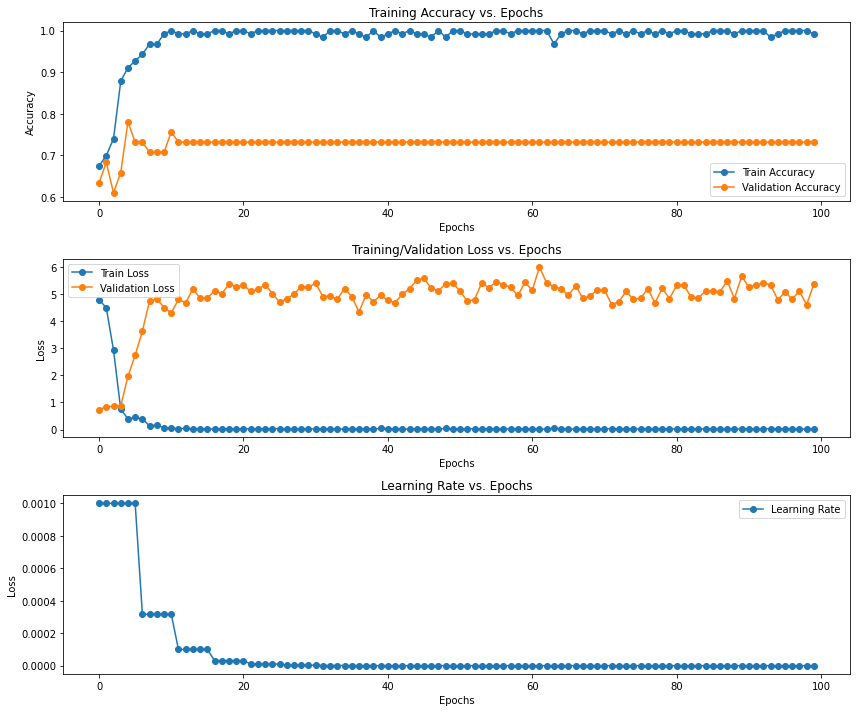

In [31]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [32]:
predictions = cnn_model.predict(test_generator)

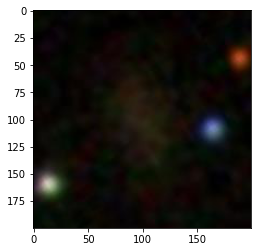

In [33]:
img0 = test_generator[2][0]
plt.figure()
plt.imshow(img0)
plt.show()

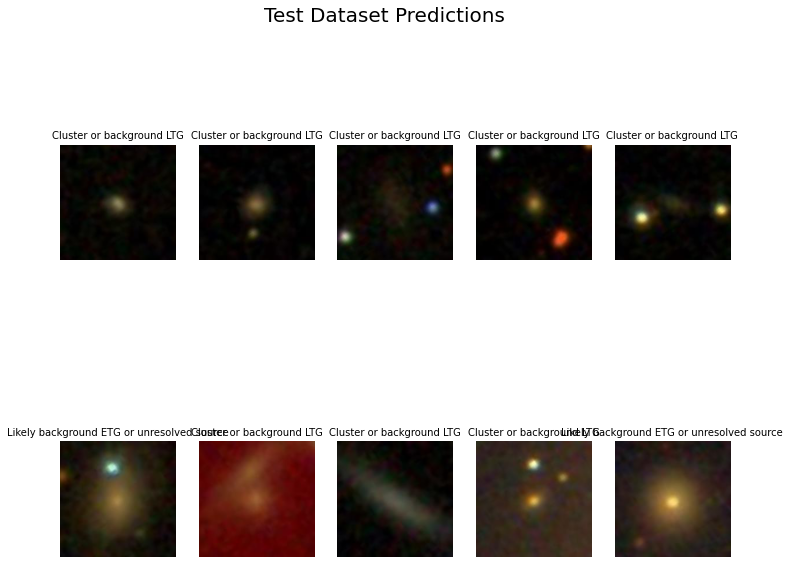

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = unique_labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}", fontsize=10)
        ax[i, j].imshow(test_generator[idx][0])
        
        ax[i, j].axis("off")
        idx += 1

# plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [35]:
test_loss, test_accuracy = cnn_model.evaluate(validation_generator, batch_size=BATCH_SIZE)

41/41 [==============================] - 0s 3ms/step - loss: 5.3668 - accuracy: 0.7317


In [36]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     5.36679744720459
Test Accuracy: 0.7317073345184326


In [37]:
y_pred = np.argmax(predictions, axis=1)
y_true = testDf['labels']
y_true = y_true.tolist()


In [38]:
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0], dtype=int64)

In [39]:
unique_labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in unique_labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : 0
1 : 1


In [40]:
# function to return key for any value
def get_key(val):
    for key, value in unique_labels.items():
        if val == value:
            return key
 
    return "key doesn't exist"

Y_true = []
for i in range(len(y_true)):
    Y_true.append(get_key(y_true[i]))

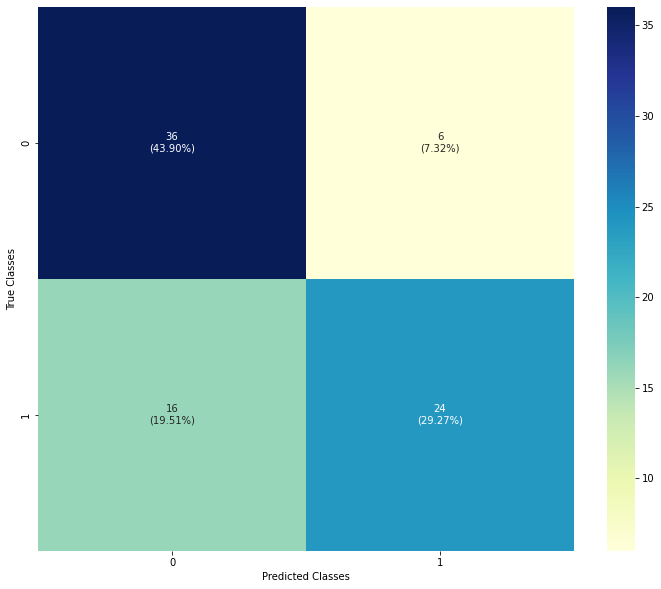

In [41]:
cf_mtx = confusion_matrix(Y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(2, 2)

plt.figure(figsize = (12, 10))
# sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
#            cmap="YlGnBu", fmt="", annot=box_labels)
sns.heatmap(cf_mtx,cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [42]:
y_true = np.array([int(x) for x in y_true]) # cast to np array for type consistency with y_pred
errors = (y_true - y_pred != 0) # everywhere the numbers don't match
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [43]:
test_images = test_generator.filenames
test_img_err = np.asarray(test_images)[errors]

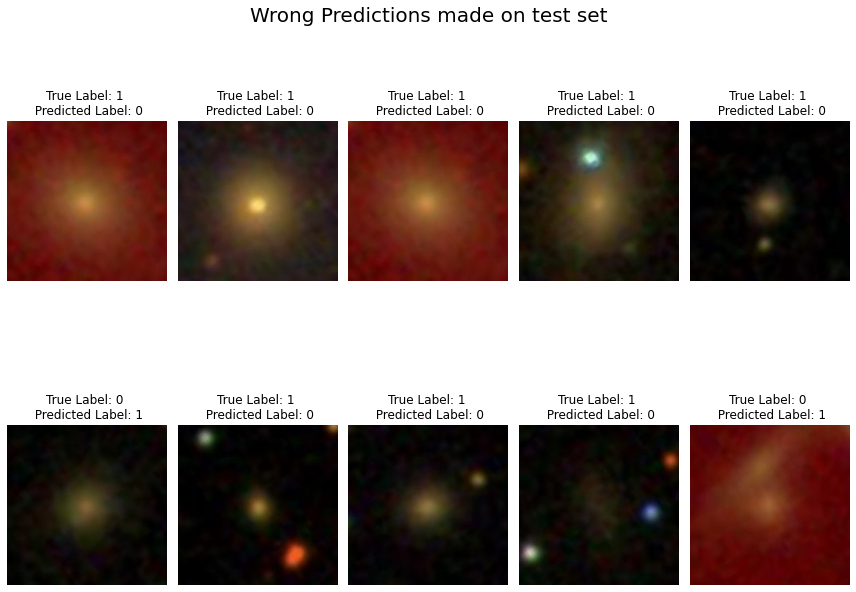

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img_err))
        true_index = y_true_errors[idx]
        true_label = unique_labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = unique_labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        ax[i, j].imshow(test_generator[idx][0])
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()

In [45]:
hits = (y_true - y_pred == 0)
y_true_hits = y_true[hits]
y_pred_hits = y_pred[hits]

In [46]:
test_img_hits = np.asarray(test_images)[hits]

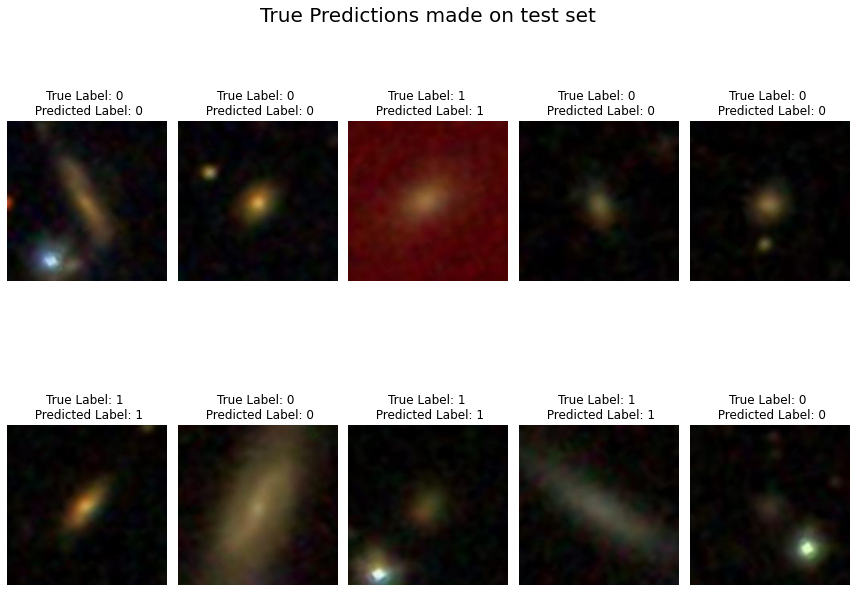

In [47]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img_hits))
        true_index = y_true_hits[idx]
        true_label = unique_labels[true_index]
        predicted_index = y_pred_hits[idx]
        predicted_label = unique_labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        ax[i, j].imshow(test_generator[idx][0])
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('True Predictions made on test set', fontsize=20)
plt.show()